### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array


### IMPORT / VIEWING / PREPROCESSING DATASET

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


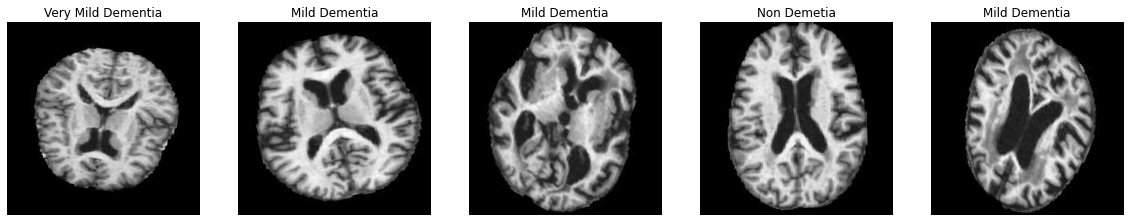

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [7]:
# Loading Model
from keras.applications.vgg19 import VGG19
base_model = VGG19(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

2023-01-07 16:42:49.541447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 16:42:49.542376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 16:42:49.746822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 16:42:49.747736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 16:42:49.748511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

80150528/80134624 [==============================] - 0s 0us/step


In [8]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [10]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
# Defining Callbacks


filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [13]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

2023-01-07 16:43:08.918289: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-07 16:43:14.764753: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 [==============================] - 136s 3s/step - loss: 1.4325 - Categorical Accuracy: 0.4858 - precision: 0.5039 - recall: 0.4392 - f1_score: 0.4733 - val_loss: 1.7429 - val_Categorical Accuracy: 0.3685 - val_precision: 0.3667 - val_recall: 0.3617 - val_f1_score: 0.3643
Epoch 2/100
33/33 [==============================] - 68s 2s/step - loss: 1.1727 - Categorical Accuracy: 0.5373 - precision: 0.5639 - recall: 0.4951 - f1_score: 0.5264 - val_loss: 1.1568 - val_Categorical Accuracy: 0.3832 - val_precision: 0.4254 - val_recall: 0.2815 - val_f1_score: 0.3389
Epoch 3/100
33/33 [==============================] - 69s 2s/step - loss: 1.0883 - Categorical Accuracy: 0.5427 - precision: 0.5744 - recall: 0.4880 - f1_score: 0.5320 - val_loss: 1.2672 - val_Categorical Accuracy: 0.3265 - val_precision: 0.4406 - val_recall: 0.1632 - val_f1_score: 0.2375
Epoch 4/100
33/33 [==============================] - 70s 2s/step - loss: 1.0044 - Categorical Accuracy: 0.5639 - precision: 0.6005 - recall: 0.5

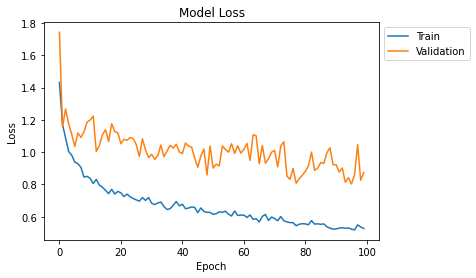

In [14]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [32]:

testgen = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',

                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             #classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             )

Found 1279 images belonging to 4 classes.


In [33]:
model.evaluate(testgen)


1279/1279 [==============================] - 18s 14ms/step - loss: 0.7961 - Categorical Accuracy: 0.6927 - precision: 0.7110 - recall: 0.6732 - f1_score: 0.6732


[0.7961423993110657,
 0.6927286982536316,
 0.7109826803207397,
 0.6731821894645691,
 0.6731821298599243]

In [26]:

true_classes = testgen.classes
class_indices = testgen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

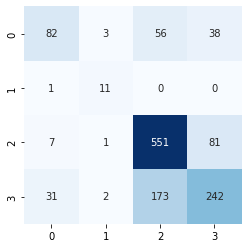

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
    )

plt.figure()
plot_heatmap(true_classes, vgg_pred_classes)    

plt.show()


In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Test on second dataset

In [45]:
test_datagen2  = ImageDataGenerator(rescale = 1./255)
# Test Data 

test_dataset2  = test_datagen.flow_from_directory(directory = '/kaggle/input/alzheimer-mri-dataset/Dataset',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 1)

Found 6400 images belonging to 4 classes.


In [46]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [47]:
# Evaluating Loss and AUC

model.evaluate(test_dataset2)

6400/6400 [==============================] - 93s 14ms/step - loss: 0.7052 - Categorical Accuracy: 0.7175 - precision: 0.7347 - recall: 0.7006 - f1_score: 0.7006


[0.7051613330841064,
 0.7174999713897705,
 0.7347206473350525,
 0.7006250023841858,
 0.700624942779541]

In [49]:

true_classes = test_dataset2.classes
class_indices = test_dataset2.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(test_dataset2)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

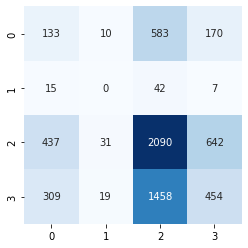

In [50]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_dataset2.class_indices.keys()

def plot_heatmap(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
    )

plt.figure()
plot_heatmap(true_classes, vgg_pred_classes)    

plt.show()
